In [ ]:
from PIL import Image
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
info = {'Image': [], 'Source': [], 'Cropped': [], 'CDR': [], 'Ecc-Cup': [], 'Ecc-Disc': [], 'Label': []}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT_DIR = '/content/drive/My Drive'

In [ ]:
import os

In [ ]:
os.listdir(ROOT_DIR)

['Colab Notebooks',
 'Datasets.gsheet',
 'Research Plan.gdoc',
 'ToDo.gdoc',
 'Models',
 'Todo.gdoc',
 'Results.gsheet',
 'ForKaggle',
 'CNN_numerical.ipynb']

In [ ]:
dataset = os.path.join(ROOT_DIR, 'ForKaggle')

In [ ]:
cropped = os.path.join(dataset, 'Cropped_Data')

In [ ]:
os.listdir(cropped)

['G1020', 'REFUGE', 'ACRIMA', 'Drishti', 'ORIGA', 'origa_g1020.csv']

In [ ]:
def get_eccentricity(cnt):
  ellipse = cv2.fitEllipse(cnt)
  center = ellipse[0]
  axis_lens = ellipse[1]
  a = max(axis_lens[0], axis_lens[1])
  b = min(axis_lens[0], axis_lens[1])
  c = ((a**2)-(b**2))**(0.5)
  return c/a

def get_major_axis_len(cnt):
  ellipse = cv2.fitEllipse(cnt)
  center = ellipse[0]
  axis_lens = ellipse[1]
  a = max(axis_lens[0], axis_lens[1])
  return a


def calc_CDR(cnt_disc, cnt_cup):
  disc_height = get_major_axis_len(cnt_disc)
  cup_height = get_major_axis_len(cnt_cup)
  return cup_height/disc_height

def get_numerical_features(mask):
  # disk
  ret,thresh = cv2.threshold(mask, 0, 1, 0)
  contours,hierarchy = cv2.findContours(thresh, 1, 2)
  cnt_disc = contours[0]
  disk_ecc = get_eccentricity(cnt_disc)

  # cup
  try:
    ret,thresh = cv2.threshold(mask, 1, 2, 0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt_cup = contours[0]
    cup_ecc = get_eccentricity(cnt_cup)
    cdr = calc_CDR(cnt_disc, cnt_cup)
  except:
    cup_ecc = np.nan
    cdr = np.nan
  return cdr, cup_ecc, disk_ecc

def get_CDR(mask):
  disc = np.sum(mask[mask == 1])
  cup = np.sum(mask[mask == 2])
  return cup/(disc+cup)

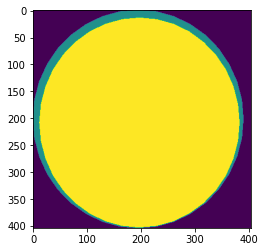

In [ ]:
sample_mask = get_mask_from_path('/content/drive/My Drive/ForKaggle/Cropped_Data/ORIGA/Masks/003.png')
plt.imshow(sample_mask)

In [ ]:
get_numerical_features(sample_mask)

(0.9620225297242785, 0.29930338121188416, 0.2628280690153354)

### ORIGA

In [ ]:
origa_dir = os.path.join(cropped, 'ORIGA')
os.listdir(origa_dir)

['Images', 'Masks', 'OrigaList.csv', 'origa_info.csv']

In [ ]:
img_dir = os.path.join(origa_dir, 'Images')
csv_path = os.path.join(origa_dir, 'OrigaList.csv')
mask_dir = os.path.join(origa_dir, 'Masks')

In [ ]:
origa_info = pd.read_csv(csv_path)
origa_info.head()

,Eye,Filename,ExpCDR,Set,Glaucoma
0,OD,001.jpg,0.7097,A,0
1,OS,002.jpg,0.6953,A,0
2,OS,003.jpg,0.9629,A,0
3,OD,004.jpg,0.7246,A,0
4,OS,005.jpg,0.6138,A,0


In [ ]:
def get_mask_from_path(path):
  return np.array(Image.open(path, mode='r'))

In [ ]:
# info = {'Image': [], 'Source': [], 'Cropped': [], 'CDR': [], 'Ecc-Cup': [], 'Ecc-Disc': [], 'Label': []}
img_paths = [os.path.join(img_dir, f) for f in origa_info['Filename']]
msk_paths = [os.path.join(mask_dir, f[:-4]+'.png') for f in origa_info['Filename']]
info['Image'].extend(img_paths)
info['CDR'].extend(list(origa_info['ExpCDR']))
info['Label'].extend(list(origa_info['Glaucoma'])) 
ecc_cup_origa = []
ecc_disc_origa = []
for f in msk_paths:
  cdr, cecc, decc = get_numerical_features(get_mask_from_path(f))
  ecc_cup_origa.append(cecc)
  ecc_disc_origa.append(decc)

info['Ecc-Cup'].extend(ecc_cup_origa)
info['Ecc-Disc'].extend(ecc_disc_origa)
source = ['Origa']*len(ecc_cup_origa)
info['Source'].extend(source)
cropped = [True]*len(ecc_cup_origa)
info['Cropped'].extend(cropped)

In [ ]:
origa_csv = pd.DataFrame(info)
origa_csv.head()

,Image,Source,Cropped,CDR,Ecc-Cup,Ecc-Disc,Label
0,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7097,0.636027,0.580909,0
1,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6953,0.575024,0.608413,0
2,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.9629,0.299303,0.262828,0
3,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7246,0.503186,0.483273,0
4,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6138,0.500141,0.283467,0


In [ ]:
origa_csv.to_csv('origa_info.csv', index=False)

### G1020

In [ ]:
cropped = os.path.join(dataset, 'Cropped_Data')
g1020_dir = os.path.join(cropped, 'G1020')
os.listdir(g1020_dir)

['Images', 'Masks', 'NerveRemoved_Images', 'G1020.csv']

In [ ]:
img_dir = os.path.join(os.path.join(g1020_dir, 'Images'), 'img')
csv_path = os.path.join(g1020_dir, 'G1020.csv')
mask_dir = os.path.join(os.path.join(g1020_dir, 'Masks'), 'img')

In [ ]:
g1020_info = pd.read_csv(csv_path)
g1020_info.head()

,imageID,binaryLabels
0,image_0.jpg,0
1,image_1.jpg,0
2,image_3.jpg,0
3,image_4.jpg,0
4,image_5.jpg,0


In [ ]:
bad_inds = ['700', '1227', '2308', '2656']

In [ ]:
to_drop = []
for index, row in g1020_info.iterrows():
  for ind in bad_inds:
    if ind in row['imageID']:
      to_drop.append(index)

In [ ]:
g1020_info.drop(labels=to_drop, axis=0, inplace=True)

In [ ]:
# info = {'Image': [], 'Source': [], 'Cropped': [], 'CDR': [], 'Ecc-Cup': [], 'Ecc-Disc': [], 'Label': []}
img_paths = [os.path.join(img_dir, f) for f in g1020_info['imageID']]
msk_paths = [os.path.join(mask_dir, f[:-4]+'.png') for f in g1020_info['imageID']]
info['Image'].extend(img_paths)
info['Label'].extend(list(g1020_info['binaryLabels'])) 
ecc_cup_g1020 = []
ecc_disc_g1020 = []
cdr_g1020 = []
for f in msk_paths:
  mask_arr = get_mask_from_path(f)
  # print(f)
  try:
    cdr, cecc, decc = get_numerical_features(mask_arr)
  except:
    print(f'ERROR Filename: {f}')
  ecc_cup_g1020.append(cecc)
  ecc_disc_g1020.append(decc)
  cdr_g1020.append(cdr)

info['CDR'].extend(cdr_g1020)
info['Ecc-Cup'].extend(ecc_cup_g1020)
info['Ecc-Disc'].extend(ecc_disc_g1020)
source = ['G1020']*len(ecc_cup_g1020)
info['Source'].extend(source)
cropped = [True]*len(ecc_cup_g1020)
info['Cropped'].extend(cropped)

In [ ]:
origa_g1020_df = pd.DataFrame(info)
origa_g1020_df.tail()

,Image,Source,Cropped,CDR,Ecc-Cup,Ecc-Disc,Label
1659,/content/drive/My Drive/ForKaggle/Cropped_Data...,G1020,True,0.366169,0.569047,0.487410,0
1660,/content/drive/My Drive/ForKaggle/Cropped_Data...,G1020,True,0.643031,0.459149,0.330510,0
1661,/content/drive/My Drive/ForKaggle/Cropped_Data...,G1020,True,0.487790,0.439424,0.439489,1
1662,/content/drive/My Drive/ForKaggle/Cropped_Data...,G1020,True,0.555098,0.466561,0.518132,1
1663,/content/drive/My Drive/ForKaggle/Cropped_Data...,G1020,True,NaN,NaN,0.852223,0


In [ ]:
origa_g1020_df.to_csv('origa_g1020.csv', index=False)